# EPA1361 - Model-Based Decision Making

# Week 4 - Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions

## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments of Week 2. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be minimized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake mode lexercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in the exercise of Week 2 had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100) over 100 days. Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following *Quinn et al. 2016* and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$)


**To formulate this problem, do the following:**

**1) Define a function for the anthropogenic pollution.**

**2) Copy the lake model function, which is the 'system model' for this problem, from your previous exercise. Modify the lake model formulation according to the new decision makign structure (levers).**

**3) Create an ema-workbench interface for this problem, with corresponding uncertainties, levers and outcomes.**

In [1]:
def anthropogenic_pollution(X_t,c1,c2,r1,r2,w1):
    w2 =1-w1
    a = 0
    for i in [1,2]:
        a += eval("w"+str(i))* abs((X_t-eval("c"+str(i)))/eval("r"+str(i)))**3
    b = max(a,0.01)
    c = min(b,0.1)
    return c

In [2]:
anthropogenic_pollution(1,0.8,1.3,1.1,0.7,0.5)

0.04236385978669671

In [3]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from scipy.optimize import brentq
import math

In [86]:
def lake_problem(
    b=0.42,          # decay rate for P in lake (0.42 = irreversible)
    q=2.0,           # recycling exponent
    mean=0.02,       # mean of natural inflows
    stdev=0.001,     # future utility discount rate
    delta=0.98,      # standard deviation of natural inflows
    alpha=0.41,       # utility from pollution
    nsamples=150,    # Monte Carlo sampling of natural inflows
    c1=1,
    c2=1,
    r1=1,
    r2=1,
    w1=0.5
#     **testdic
):
    
#     print ( c1,c2,r1,r2,w1)
#     print(b,q,mean,stdev, delta, alpha, nsamples)
    max_P = []
    utility = []
    inertia = []
    
    Pcrit = brentq(lambda x: x**q / (1 + x**q) - b * x, 0.01, 1.5)
    nvars = 100
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    reliability = 0.0
    
    new_decisions = np.zeros(nvars)
    
    for _ in range(nsamples):
        X[0] = 0.0

        natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=nvars)

        for t in range(1, nvars):
            new_decisions[t] = anthropogenic_pollution(X[t-1],c1,c2,r1,r2,w1)
            X[t] = (1 - b) * X[t - 1] + X[t - 1]**q / (1 + X[t - 1]**q) + new_decisions[t] + natural_inflows[t - 1]
            average_daily_P[t] += X[t] / float(nsamples)

        reliability += np.sum(X < Pcrit) / float(nsamples * nvars)

    
        max_P.append(np.max(average_daily_P))
    #     print(len(decisions))
        utility.append(np.sum(alpha * new_decisions * np.power(delta, np.arange(nvars))))
        inertia.append(np.sum(np.diff(new_decisions) > -0.02) / float(nvars - 1))

    return np.mean(max_P), np.mean(utility), np.mean(inertia), np.mean(reliability)

In [7]:
# imports
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, Constant, ScalarOutcome)

from ema_workbench.analysis.plotting import lines
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [76]:
from ema_workbench.em_framework.outcomes import AbstractOutcome

In [87]:
# Instantiate EMA Workbench model
lake_model = Model('lakepython', function=lake_problem)

lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

lake_model.outcomes = [ScalarOutcome('max_P',kind=AbstractOutcome.MINIMIZE),
                       ScalarOutcome('utility',kind=AbstractOutcome.MAXIMIZE),
                       ScalarOutcome('inertia',kind=AbstractOutcome.MINIMIZE),
                       ScalarOutcome('reliability',kind=AbstractOutcome.MAXIMIZE)]

lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 150)]

lake_model.levers = [
                     RealParameter('c1',-2,2),
                     RealParameter('c2',-2,2),
                     RealParameter('r1',0,2),
                     RealParameter('r2',0,2),
                     RealParameter('w1',0,1)]

In [25]:
# results = perform_experiments(lake_model,scenarios=10, policies=10)

## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate solutions are identified by searching for the Pareto optimal values of decision **levers** with respect to the **outcomes**. This *search* is done with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

*Platypus* is python package developed by David Hadka (http://platypus.readthedocs.io/en/latest/) for multi-objective optimization. It allows an explicit specification of the problem components (levers, objectives, constraints). The package includes several multi-objective evolutionary algorithms, therefore the users can choose the algorithm they wish to use. 

Unfortunately you cannot install Platypus with **pip install**. You should download (or clone) the source code from github (https://github.com/Project-Platypus/Platypus). Open a command prompt, go to the directory you saved platypus, and run the command **python setup.py install**. 

In this exercise, I recommend to use Platypus with the ε-NSGAII algorithm, since it is shown to outperform many MOEA’s. For other algortihms, see the documentation of Platypus. For a comparison of them, you can have a look at 

    Reed, P. M., D. Hadka, J. D. Herman, J. R. Kasprzyk, and J. B. Kollat. 2013. "Evolutionary multiobjective optimization in water resources: The past, present, and future."  Advances in Water Resources 51:438-456. doi: http://dx.doi.org/10.1016/j.advwatres.2012.01.005.
    

To run multi-objective optimization on the lake model, an interface between Platypus and EMA-workbench is needed. Namely, we need to specify the *function evaluation* step, where the lake model will be called with a specific *policy*, which is composed of lever values determined by the search algorithm. Therefore,

**Write a function, which takes a list of parameter values, an EMA model instance and a list of EMA lever instances as inputs. The function should run the model with the given parameter values, and return the model results.**

**Then write a function that defines an optimization problem, and solves it.**

**You can as well just fill in the missing parts in the functions below, which are indicated by ===WRITE THE CODE HERE===**

In [13]:
# import sys

In [15]:
# sys.path.append ("C:/Users/Gebruiker/Documents/GitHub/Platypus/")

In [16]:
# sys.path

In [17]:
lake_model.uncertainties['b']

RealParameter('b', 0.1, 0.45)

In [18]:
# Example Platypus
from platypus import NSGAII, Problem, Real

def schaffer(x):
    return [x[0]**2, (x[0]-2)**2]

problem = Problem(1, 2)
problem.types[:] = Real(-10, 10)
problem.function = schaffer

algorithm = NSGAII(problem)
algorithm.run(100)

In [20]:
algorithm.result[0]

Solution[9.009075874752497|81.16344811704748,49.127144618037484|0]

In [88]:
from ema_workbench.em_framework import (Scenario, Policy)
from ema_workbench.em_framework.outcomes import AbstractOutcome

def evaluate_function(x, model=None, decision_vars=None):
    '''helper function for transforming decision variables to correctly
    formatted input for running the model
    
    Parameters
    ----------
    x : list of lever values
    model : a Model instance
    decision_vars : list of Parameter instances 
    
    note:: model and decision_vars are preloaded through functools.partial
    
    returns a list of objective function values
    
    '''

    # === YOU CAN WRITE THE CONTENT OF THE FUNCTION HERE.===
#     levers = {'c1':x[0],'c2':x[1],'r1':x[2],'r2':x[3],'w1':x[4]}
    levers = dict(zip(decision_vars, x))
    
    
    policy = Policy("", **levers)
    model.policy = policy
    model.run_model(scenario=Scenario(), policy=policy )
    
    outcomes = [x for x in model.output.values()]
    
    return outcomes

In [89]:
evaluate_function([1,1,1,1,0.34],lake_model, ['c1','c2','r1','r2','w1'])

[1.1495198537200277,
 1.527626606023879,
 0.97979797979797978,
 0.06999999999999991]

In [51]:
lake_problem(c1=1,c2=1,r1=1,r2=1,w1=0.34)

1 1 1 1 0.34
0.42 2.0 0.02 0.001 0.98 0.41 150


(1.1495187377790781,
 1.5277569361429681,
 0.97979797979797978,
 0.06999999999999991)

Now, the algorthm can use this *evaluate_function* to evaluate each alternative solution.

We still need to specify an optimization problem in Platypus. We can first write a generic function that can be used for any model and any algorithm. If you would like to try this by yourself, see the simple example in Platypus documentation.  

In [52]:
from platypus import Problem, unique, nondominated, Real, EpsNSGAII
import functools
import pandas as pd

In [94]:
# platypus testmodel
def belegundu(vars):
    x = vars[0]
    y = vars[1]
    return [-2*x + y, 2*x + y], [-x + y - 1, x + y - 7]

problem = Problem(2, 2, 2)
problem.types[:] = [Real(0, 5), Real(0, 3)]
problem.constraints[:] = "<=0"
problem.function = belegundu

algorithm = NSGAII(problem)
algorithm.run(100)

In [95]:
algorithm.result

[Solution[4.140186150307872,1.6998920595553402|-6.580480241060403,9.980264360171084|0],
 Solution[3.175756491334376,2.0533101998570604|-4.298202782811692,8.404823182525814|0],
 Solution[0.08204327036236803,1.9885780183523694|1.8244914776276333,2.152664559077105|0.9065347479900012],
 Solution[0.924246750448644,1.8375413398520646|-0.010952161045223452,3.6860348407493526|0],
 Solution[1.0775780322884987,2.163898931615235|0.008742867038237456,4.319054996192232|0.08632089932673614],
 Solution[4.397623611493482,1.8829551997069296|-6.912292023280035,10.678202422693893|0],
 Solution[1.9316884736925533,0.14809802424294538|-3.715278923142161,4.0114749716280516|0],
 Solution[3.8513856992821283,1.4109697848065725|-6.291801613757684,9.113741183370829|0],
 Solution[3.935127733093883,2.6811060561633924|-5.189149410024374,10.551361522351158|0],
 Solution[0.2767065935968088,0.9076950865522403|0.35428189935862264,1.4611082737458578|0],
 Solution[1.2536823528366225,1.73218839201554|-0.775176313657705,4.2

In [174]:
def optimize(model, algorithm=EpsNSGAII, nfe=10000, epsilons=[]):
    '''
    model : a Model instance
    algorith : a valid Platypus optimization algorithm
    nfe : int
    searchover : {'uncertainties', 'levers'}
    
    Returns the results in a pandas DataFrame
    
    '''
    
    # extract the levers and outcomes from the model
    # === WRITE THE CODE ===
    decision_variables = [dv for dv in getattr(lake_model, 'levers')]
    outcomes = [outcome for outcome in getattr(lake_model, 'outcomes')]
    
    # set the evaluation function, with the given model and decision variables 
    lever_names = [l.name for l in model.levers]
    evalfunc = functools.partial(evaluate_function, model=model,
                                 decision_vars=lever_names)
    
    # setup the optimization problem
    problem = Problem(len(decision_variables),len(outcomes))
    
    # creating a 'problem' instance first requires specifying the number of decision variables number of objectives 
    #specify the type of decision variables, e.g. real or integer, 
     #and their search ranges, by creatign a platypus Real instance for each decision variable. 
    problem.types[:] = [Real(dv.lower_bound, dv.upper_bound) 
                        for dv in decision_variables]
    #set the evaluation function
    problem.function = evalfunc
    #specify whether the objectives are to be minimized or maximized. 
     #Remember that we set these when we created the outcomes of the ema model. 
    problem.directions = [outcome.kind for outcome in outcomes]

    # solve the optimization problem
    optimizer = algorithm(problem, epsilons)
    optimizer.run(nfe)

    # extract the results from the optimizer and save in a dataframe
    
    # ensure that eventual results are nondominated and do not have duplicates
    results = unique(nondominated(optimizer.result))
        # results is a list of 'solution' objects, 
        #which has the decision variable values in solution.variables 
        #and objective values in solution.objectives 
    
    # for the dataframe, get the names for levers and the outcomes
    # === WRITE THE CODE HERE === 
    lever_names = lever_names
    outcome_names = [l for l in lake_model.outcome_variables]
        
    
    vars_dict = dict()
    out_dict = dict()
    for i, solution in enumerate(test):
        decision_vars = dict(zip(lever_names, solution.variables))
        decision_out = dict(zip(outcome_names, solution.objectives))

        vars_dict[i] = decision_vars
        out_dict[i] = decision_out

    df1 = pd.DataFrame.from_dict(vars_dict, orient='index')
    df2 = pd.DataFrame.from_dict(out_dict, orient='index')

    results = pd.concat([df1,df2], axis=1)
    
    
    
#     solutions = []
#     for solution in results:
#         #for each solution, match the lever names with variable values, and outcome names with objective values 
#         decision_vars = dict(zip(lever_names, solution.variables))
#         decision_out = dict(zip(outcome_names, solution.objectives))
#         #create dictionary, with the unpacked keys and values of the above two dictionaries. This will be row in th df.
#         # === WRITE THE CODE HERE ===

#     results = pd.DataFrame(solutions, columns=lever_names+outcome_names)

    return results

We can now call the *optimize* function for the lake problem, and run the search algorithm. I set the maximum number of function evaluations (when the algorithm will stop) as 10000, and specify the epsilon values differently for each objective. You can then save the esults in a csv file, to be used later.

In [175]:
results = optimize(lake_model,nfe=101, epsilons=[0.05,0.01,0.005,0.005])

In [178]:
results.head()

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,1.962267,1.893324,1.833229,0.775416,0.371441,0.987193,0.576721,0.979798,0.070000
1,1.795892,0.959988,1.546418,0.192524,0.415805,1.149525,1.725183,0.989899,0.069933
2,1.044838,0.696163,1.726184,1.961521,0.365385,1.149654,0.963334,0.989899,0.274200
3,-0.122550,-1.230429,1.650106,1.876212,0.943866,1.149561,1.035608,1.000000,0.355400
4,1.044838,0.440762,1.726184,1.961521,0.365385,1.149475,0.839985,0.989899,0.392200


In [8]:
# it should look like that
results.head()

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.322631,-0.007120,0.184671,1.187875,0.051311,2.283747,1.735253,0.010101,0.0785
1,0.008308,0.083819,0.633691,1.912900,0.102964,2.283749,1.501186,0.016162,0.1500
2,-0.036953,0.109136,1.274177,1.131946,0.079583,2.283858,1.672452,0.040404,0.1000
3,0.219833,0.083819,1.345225,1.626325,0.102964,2.283888,1.547436,0.023636,0.1400
4,0.711100,0.063893,1.019463,1.849839,0.023915,2.283800,1.590335,0.010101,0.1200


We have found 336 unique nondominated solutions that specify a value for each of the five decision levers. (Note that you may find a different number of solutions.) Remember that solution *a* dominates solution *b* if it is equal to or better than it in terms of all objectives. A nondominated solution is equal to or better than all other solutions in terms of at least one objecive. Therefore, each solution is actually a tradeoff between the multiple. possible conflicting objectives. 

We can visualize these tradeoffs on **parallel coordinate plots**, which have a column (vertical axis) for each objective. Each solution is represetned by a line on this plot, which crosses the objective axes at the corresponsing value.

**As an exercise, you can plot the tradeoffs you have found on a parallel plot. Note that the values on each axis should be normalized to ensure a reasonable comparison.**



In [185]:
results2 = results.reset_index()

In [33]:
int()

In [180]:
from pandas.tools.plotting import parallel_coordinates

In [181]:
plt.figure()

In [195]:
parallel_coordinates(results2[oois+['index']], 'index')

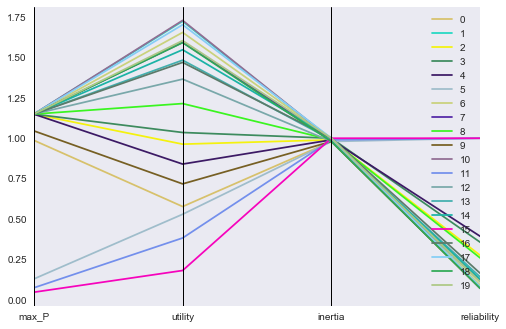

In [196]:
plt.show()

In [189]:
# THIS IS HOW IT CAN LOOK LIKE

oois = [out.name for out in lake_model.outcomes]
objectives = results.ix[:, oois]

title = "Non-dominated tradeoffs"
# plot_optimal(objectives, oois, title)

In [190]:
oois

['max_P', 'utility', 'inertia', 'reliability']

In [191]:
objectives

,max_P,utility,inertia,reliability
0,0.987193,0.576721,0.979798,0.070000
1,1.149525,1.725183,0.989899,0.069933
2,1.149654,0.963334,0.989899,0.274200
3,1.149561,1.035608,1.000000,0.355400
4,1.149475,0.839985,0.989899,0.392200
5,0.128080,0.528925,0.979798,1.000000
6,1.149496,1.655677,1.000000,0.090000
7,1.149573,1.594199,0.993266,0.119667
8,1.149536,1.214728,0.989899,0.257867
9,1.045695,0.717148,0.979798,0.070000


**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Step 3: Explore the scenarios and robustness of candidate solutions

We now have a large number of candidate solutions (policies), we can evaluate them in terms of their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we need 336000 scenarios. 

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**

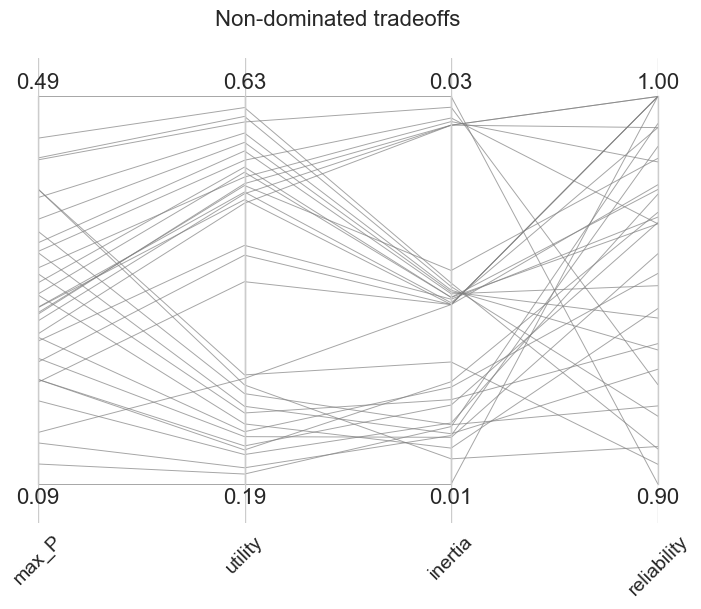

In [62]:
#using the predefined parallel plot function, plot the reduced set of tradeoffs
new_objectives = new_results.ix[:, oois]
plot_optimal(new_objectives, oois, title)

**From new_results, which is the reduced dataframe of candidate solutions, make list of policies in a fromat that can be inputed to the *perform_experiments* function of the EMA workbench.**

**Perform 1000 scenarios for each of the policy options. Considering that there are 35 policy options and we need to run 35000 experiments in total, and we can consider using the IpyparallelEvaluator**

If you want to use ipyprallel, don't forget to start ipcluster.

We can now evaluate the **robustness** of each of the 35 policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation shoudl be different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of that scenario and the berformance of a no-regret or refeence policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We off course favor policy options with low *maximum regret* values. (You can find furter explanation in the slides of the Advanced System Dynamics course.)

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [ ]:
def x(x, a=1, b=2):
    return x

def y(parameters, func=x, a=1, b=2)
    return func(parameters, a=a, b=b)